# Figure 11: Proxy noise
This notebook can be used to: 
- Generate/load and plot the synthetic d13C and age constraint data used for the white noise experiments in Fig. 11
- Build and sample the inference model using proxy observations with different amplitudes of added white noise
- Load the inference results from the model runs used to produce Fig. 11
- Quantify signal recovery for each experiment
- Reproduce Fig. 11 using the provided inference results

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import rcParams

import stratmc

rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Avenir"]
rcParams.update({"text.usetex": False})

import warnings

from scipy.ndimage import gaussian_filter as gaussian
from scipy.stats import gaussian_kde, norm
from tqdm.notebook import tqdm

warnings.simplefilter(action="ignore", category=FutureWarning)

## Synthetic d13C signal (Fig. 6a)

(130.0, 100.0)

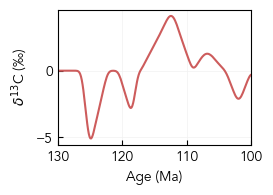

In [12]:
age_vector = np.linspace(100, 130, 250)
amplitude = [-6, -3.5, 4.5, 1.5, -2.5]
seed = 5
d13c_signal = stratmc.synthetics.make_excursion(
    age_vector,
    amplitude,
    excursion_duration=[4, 3, 8, 5, 4],
    rising_time=[0.3, 0.7, 0.6, 0.4, 0.5],
    smooth=True,
    smoothing_factor=5,
    rate_offset=True,
    seed=seed,
    baseline=0,
)  # seed = 3
d13c_signal = gaussian(np.flip(d13c_signal), 3)


fs = 10

fig = plt.figure(figsize=(2.5, 1.75))
ax = fig.gca()

ax.plot(age_vector, d13c_signal, color="indianred", lw=1.5)  # '#87BED5'
ax.set_xlabel("Age (Ma)", fontsize=fs)
ax.set_ylabel("$\delta^{13}$C (‰)", fontsize=fs)
ax.tick_params(direction="in", labelsize=fs)
ax.set_axisbelow(True)
ax.grid(color=(0.95, 0.95, 0.95), linewidth=0.5, linestyle="solid", zorder=-1)
ax.set_xlim([130, 100])

In [13]:
def signal_func(new_ages):
    return np.interp(new_ages, age_vector, d13c_signal)

## Construct gamma age models
To load the observations directly (instead of generating it yourself), skip this section and run the [Load the data](#Load-the-data) section instead

In [14]:
def make_path(pts, g_shape, g_scale, delta):
    # separate a number of points (X) along a [0,1] path
    if pts != 0:
        # X numbers are drawn from a gamma distribution (G)
        # --> these represent the distances between successive points
        path = np.cumsum(np.random.gamma(g_shape, g_scale, pts))
    else:
        path = [1]  # if X = 0, then path is simply [0,1]
    path = np.hstack((0, path))  # add 0 as the path beginning
    # scale first to be between 0 and 1, and then 0 to delta
    path = path / path[-1] * delta
    return path

In [15]:
delta_h = 30
g_shape = 100

sections = ["1", "2", "3", "4"]

sample_dfs = {}
ages_dfs = {}

sample_ages = np.array([])
sample_heights = np.array([])
proxy_vec = np.array([])
section_names = []
age_heights = []
ages_vec = []
ages_std_vec = []
age_section_names = []

# age constraints for each section
ages = {}
ages_std = {}

ages["1"] = [130, 100.5]
ages_std["1"] = [2, 1]

ages["2"] = [128, 100]
ages_std["2"] = [1.5, 0.75]

ages["3"] = [129, 100]
ages_std["3"] = [0.8, 1]

ages["4"] = [130, 101]
ages_std["4"] = [2.5, 1.5]


for section in sections:
    delta_t = ages[section][0] - ages[section][-1]

    np.random.seed(int(section) * 3)

    samples = 29
    sample_ages_temp = ages[section][0] - make_path(
        samples, g_shape, 1, delta_t
    )  # age change between knots
    sample_ages = np.append(sample_ages, sample_ages_temp)

    # high k so that change in height is relatively constant (to simulate a constant stratigraphic sampling rate)
    heights = make_path(samples, 100, 1, delta_h) + 0.1  # position change between knots
    sample_heights = np.append(sample_heights, heights)

    section_proxy = signal_func(sample_ages_temp)
    proxy_vec = np.append(proxy_vec, section_proxy)

    for i in np.arange(len(section_proxy)):
        section_names.append(section)

    age_heights.append(0)
    age_heights.append(np.max(heights) + 0.1)
    ages_vec += ages[section]
    ages_std_vec += ages_std[section]

    for i in np.arange(2):
        age_section_names.append(section)


ages_df, sample_df = stratmc.synthetics.synthetic_signal_to_df(
    proxy_vec,
    sample_heights,
    sample_ages,
    section_names,
    ages_vec,
    ages_std_vec,
    age_heights,
    age_section_names,
    proxies=["d13c"],
)

ages_df["param_1"] = np.nan
ages_df["param_2"] = np.nan
ages_df["param_1_name"] = np.nan
ages_df["param_2_name"] = np.nan

Text(0.5, 1.0, 'k = 100')

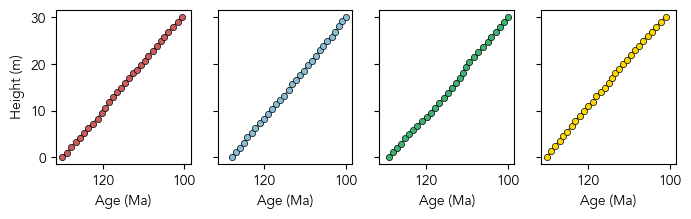

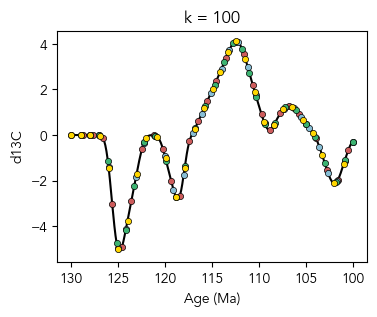

In [7]:
# plot 1) the true age model for each section, and 2) the proxy observations on top of the synthetic signal
sections = np.unique(sample_df["section"])

section_cs = {}
section_cs["1"] = "indianred"
section_cs["2"] = "#87BED5"
section_cs["3"] = "mediumseagreen"
section_cs["4"] = "gold"


fig, ax = plt.subplots(1, 4, figsize=(8, 2), sharex=True, sharey=True)
fig2 = plt.figure(figsize=(4, 3))
ax2 = fig2.gca()


for i in np.arange(len(sections)):

    section = sections[i]

    ax[i].plot(
        sample_df[sample_df["section"] == section]["age"],
        sample_df[sample_df["section"] == section]["height"],
        c="gray",
        zorder=1,
    )

    ax[i].scatter(
        sample_df[sample_df["section"] == section]["age"],
        sample_df[sample_df["section"] == section]["height"],
        s=20,
        c=section_cs[section],
        edgecolor="k",
        lw=0.5,
        zorder=2,
    )

    ax[i].set_xlabel("Age (Ma)")

    ax2.scatter(
        sample_df[sample_df["section"] == section]["age"],
        sample_df[sample_df["section"] == section]["d13c"],
        color=section_cs[section],
        edgecolor="k",
        lw=0.5,
        s=20,
        zorder=2,
    )

ax2.plot(age_vector, d13c_signal, color="k", zorder=1)


ax[0].invert_xaxis()
ax[0].set_ylabel("Height (m)")


ax2.invert_xaxis()
ax2.set_xlabel("Age (Ma)")
ax2.set_ylabel("d13C")
ax2.set_title("k = " + str(g_shape))

In [17]:
# stratmc.data.save_object(sample_df, 'data/proxy_noise_sample_df_unmodified')
# stratmc.data.save_object(ages_df, 'data/proxy_noise_ages_df')

## Load the data
Load the data that were generated in the [Construct gamma age models](#Construct-gamma-age-models) section. 

In [18]:
sections = ["1", "2", "3", "4"]

sample_df = stratmc.data.load_object("data/Fig11_proxy_noise_sample_df_unmodified")
ages_df = stratmc.data.load_object("data/Fig11_proxy_noise_ages_df")

## Make lithostratigraphy for each section

In [8]:
facies_colors = {}
facies_widths = {}

facies_colors["limestone"] = "#F4F2F3"

facies_widths["limestone"] = 0.75

section_facies = {}
section_facies_thicknesses = {}

# section 1
section_facies["1"] = ["limestone"]
section_facies_thicknesses["1"] = [np.max(ages_df[ages_df["section"] == "1"]["height"])]


# section 2
section_facies["2"] = ["limestone"]
section_facies_thicknesses["2"] = [np.max(ages_df[ages_df["section"] == "2"]["height"])]

# section 3
section_facies["3"] = ["limestone"]
section_facies_thicknesses["3"] = [np.max(ages_df[ages_df["section"] == "3"]["height"])]

# section 4
section_facies["4"] = ["limestone"]
section_facies_thicknesses["4"] = [np.max(ages_df[ages_df["section"] == "4"]["height"])]

# save the unmodified d13C values
sample_df["d13c_original"] = sample_df["d13c"].copy()

sample_df, ages_df = stratmc.data.clean_data(sample_df, ages_df, ["d13c"], sections)

## Add white noise to proxy observations
For each experiment, add white noise with amplitude between 0.5 and 5 permil to the data. To generate the data for each trial, change `np.random.seed` as directed. You can also skip this section and load the modified observations for each trial in [Load the modified proxy data](#Load-the-modified-proxy-data).

In [10]:
# concatenating two arrays to make sure the data are reproducible (after adding new test amplitudes)
noise_amp = np.concatenate(
    [np.arange(0.5, 5.5, 0.5), np.array([0.75, 1.25, 1.75, 2.25])]
)

## modify the random seed for each trial
# trial 1: np.random.seed(0)
# trial 2: np.random.seed(1)
# trial 3: np.random.seed(2)
np.random.seed(2)

sample_dfs_white = {}

for amp in noise_amp:
    sample_dfs_white[amp] = sample_df.copy()
    sample_dfs_white[amp]["d13c"] = sample_dfs_white[amp][
        "d13c_original"
    ] + np.random.normal(0, amp, len(sample_dfs_white[amp]["d13c"].values))

# save the modified data
# stratmc.data.save_object(sample_dfs_white, 'data/Fig11_white_noise_sample_df_trial_3')

## Load the modified proxy data
Load the modified proxy observations generated in [Add white noise to proxy observations](#Add-white-noise-to-proxy-observations).

In [12]:
noise_amp = np.concatenate(
    [np.arange(0.5, 5.5, 0.5), np.array([0.75, 1.25, 1.75, 2.25])]
)

# trial 1
# sample_dfs_white = stratmc.data.load_object('data/Fig11_white_noise_sample_df_trial_1')

# trial 2
# sample_dfs_white = stratmc.data.load_object('data/Fig11_white_noise_sample_df_trial_1')

# trial 3
sample_dfs_white = stratmc.data.load_object("data/Fig11_white_noise_sample_df_trial_3")

## Example proxy observations for Section 1 (Fig. 11a)

Text(0, 0.5, 'Height (m)')

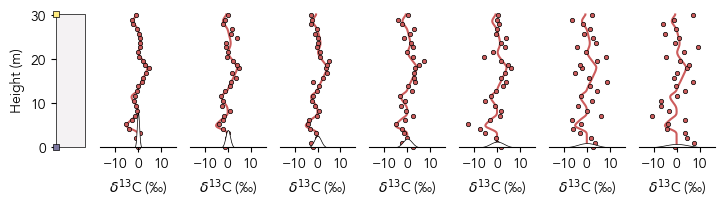

In [13]:
np.random.seed(0)

age_colors = {}
age_colors["1"] = ["#7C78A0", "#FFEB7F"]
age_colors["2"] = ["#87BED5", "mediumseagreen"]
age_colors["3"] = ["#F4A27C", "gray"]
age_colors["4"] = ["pink", "white"]

xs = np.linspace(-15, 15, 500)

section = "1"

widths = [0.4] + 7 * [1]
fig, ax = plt.subplots(
    1,
    8,
    figsize=(8.5, 1.75),
    sharey=True,
    sharex=False,
    gridspec_kw={"width_ratios": widths},
)

_ = [ax[i].sharex(ax[1]) for i in np.arange(1, 8)]

idx = [0, 1, 2, 3, 5, 7, 9]
for amp, i in zip(noise_amp[idx], np.arange(1, 1 + len(idx))):
    section_ages_df = ages_df[
        (ages_df["section"] == section)
        & (~np.isnan(ages_df["age"]))
        & (~ages_df["intermediate detrital?"])
    ]
    section_df = sample_df[sample_df["section"] == section]

    sec_sample_ages = sample_df[sample_df["section"] == section]["age"].values
    sec_sample_heights = sample_df[sample_df["section"] == section]["height"].values

    sec_radio_ages = section_ages_df["age"].values
    sec_ages_comb = np.concatenate([sec_radio_ages, section_df["age"]])

    heights_comb = np.concatenate([section_ages_df["height"], section_df["height"]])

    heights_comb_sort_idx = np.argsort(heights_comb)

    sec_ages_comb = sec_ages_comb[heights_comb_sort_idx]
    heights_comb = heights_comb[heights_comb_sort_idx]

    new_heights = np.linspace(np.min(heights_comb), np.max(heights_comb), 400)
    sec_age_interp = np.interp(new_heights, heights_comb, sec_ages_comb)

    d13c_section_interp = np.interp(sec_age_interp, age_vector, d13c_signal)

    ax[i].plot(d13c_section_interp, new_heights, c="indianred", zorder=0)

    section_df = sample_dfs_white[amp][sample_dfs_white[amp]["section"] == section]

    ax[i].scatter(
        section_df["d13c"],
        section_df["height"],
        s=10,
        color="indianred",
        lw=0.5,
        edgecolor="k",
        clip_on=False,
        zorder=1,
    )

    pdf = norm.pdf(xs, loc=0, scale=amp)
    ax[i].fill_between(xs, pdf * 10, color="white", edgecolor="k", lw=0.5, zorder=2)


ax[1].set_ylim([0, np.max(section_df["height"]) + 0.5])

for i in np.arange(1, 8):
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["bottom"].set_visible(True)
    ax[i].spines["left"].set_visible(False)

    [t.set_color("none") for t in ax[i].yaxis.get_ticklabels()]
    ax[i].tick_params(axis="y", color="none")
    ax[i].set_xticks([-10, 0, 10])


# strat column
current_base = 0
for facies, thickness in zip(
    section_facies[section], section_facies_thicknesses[section]
):
    ax[0].barh(
        y=current_base,
        width=facies_widths[facies],
        height=thickness,
        linewidth=0.5,
        edgecolor="k",
        align="edge",
        color=facies_colors[facies],
        clip_on=False,
    )
    current_base += thickness

ax[0].scatter(
    0,
    ages_df[ages_df["section"] == section]["height"].iloc[0],
    color=age_colors[section][0],
    zorder=9,
    edgecolor="k",
    clip_on=False,
    lw=0.5,
    s=20,
    marker="s",
)
ax[0].scatter(
    0,
    ages_df[ages_df["section"] == section]["height"].iloc[1],
    color=age_colors[section][1],
    zorder=9,
    edgecolor="k",
    clip_on=False,
    lw=0.5,
    s=20,
    marker="s",
)


ax[0].set_xticks([])

ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)
ax[0].spines["bottom"].set_visible(False)
ax[0].spines["left"].set_visible(False)

for axis in ax.ravel()[1:]:
    axis.set_xlabel("$\delta^{13}$C (‰)", fontsize=fs)

ax[0].set_ylabel("Height (m)", fontsize=fs)

## Run experiments (build and sample the inference model)
Runs the inference model in a loop that iterates over each noise amplitude, and plots each proxy signal inference. The traces for each trial can be loaded in [Load the inference results](#Load-the-inference-results).

In [ ]:
age_min = 100
age_max = 130

predict_ages = np.arange(age_min, age_max + 0.25, 0.25)[:, None]

target_accept = 0.9

# current trial number (used for saving)
trial = 3

for amp in noise_amp:
    model, gp = stratmc.model.build_model(
        sample_dfs_white[amp],
        ages_df,
        proxies=["d13c"],
        ls_dist="Wald",
        ls_min=2,
        ls_mu=4,
        ls_lambda=15,
        noise_type="section",  # per-section noise with default prior
        offset_type="section",  # per-section offset with default prior
    )

    extension = "Fig11_white_noise_trial_" + str(trial) + "_noise_amp_" + str(amp)

    full_trace = stratmc.inference.get_trace(
        model,
        gp,
        predict_ages,
        sample_dfs_white[amp],
        ages_df,
        proxies=["d13c"],
        name=extension,
        chains=100,
        target_accept=0.9,
    )

    # plot the proxy signal inference for the current noise amplitude
    fig = stratmc.plotting.proxy_inference(
        sample_dfs_white[amp],
        ages_df,
        full_trace,
        orientation="horizontal",
        plot_constraints=True,
        plot_data=True,
        legend=False,
        section_legend=True,
    )

    ax = fig.gca()
    ax.plot(
        age_vector, d13c_signal, color="indianred", label="Synthetic signal", zorder=10
    )

    plt.title(amp)

    plt.legend()

    plt.show()

## Load the inference results
Create dictionaries of paths to saved `NetCDF` files with the traces. We'll use the paths to calculate signal recovery/plot the results without loading all of the traces at once (which consumes a lot of memory). 

### Dictionary of trace paths
Keys = noise amplitudes

#### Trial 1

In [15]:
trace_paths_white_1 = {}

trace_paths_white_1[0.5] = "traces/" + "Fig11_white_noise_trial_1_noise_amp_0.5"
trace_paths_white_1[0.75] = "traces/" + "Fig11_white_noise_trial_1_noise_amp_0.75"
trace_paths_white_1[1] = "traces/" + "Fig11_white_noise_trial_1_noise_amp_1.0"
trace_paths_white_1[1.25] = "traces/" + "Fig11_white_noise_trial_1_noise_amp_1.25"
trace_paths_white_1[1.5] = "traces/" + "Fig11_white_noise_trial_1_noise_amp_1.5"
trace_paths_white_1[1.75] = "traces/" + "Fig11_white_noise_trial_1_noise_amp_1.75"
trace_paths_white_1[2] = "traces/" + "Fig11_white_noise_trial_1_noise_amp_2.0"
trace_paths_white_1[2.25] = "traces/" + "Fig11_white_noise_trial_1_noise_amp_2.25"
trace_paths_white_1[2.5] = "traces/" + "Fig11_white_noise_trial_1_noise_amp_2.5"
trace_paths_white_1[3] = "traces/" + "Fig11_white_noise_trial_1_noise_amp_3.0"
trace_paths_white_1[3.5] = "traces/" + "Fig11_white_noise_trial_1_noise_amp_3.5"
trace_paths_white_1[4] = "traces/" + "Fig11_white_noise_trial_1_noise_amp_4.0"
trace_paths_white_1[4.5] = "traces/" + "Fig11_white_noise_trial_1_noise_amp_4.5"
trace_paths_white_1[5] = "traces/" + "Fig11_white_noise_trial_1_noise_amp_5.0"

#### Trial 2

In [16]:
trace_paths_white_2 = {}

trace_paths_white_2[0.5] = "traces/" + "Fig11_white_noise_trial_2_noise_amp_0.5"
trace_paths_white_2[0.75] = "traces/" + "Fig11_white_noise_trial_2_noise_amp_0.75"
trace_paths_white_2[1] = "traces/" + "Fig11_white_noise_trial_2_noise_amp_1.0"
trace_paths_white_2[1.25] = "traces/" + "Fig11_white_noise_trial_2_noise_amp_1.25"
trace_paths_white_2[1.5] = "traces/" + "Fig11_white_noise_trial_2_noise_amp_1.5"
trace_paths_white_2[1.75] = "traces/" + "Fig11_white_noise_trial_2_noise_amp_1.75"
trace_paths_white_2[2] = "traces/" + "Fig11_white_noise_trial_2_noise_amp_2.0"
trace_paths_white_2[2.25] = "traces/" + "Fig11_white_noise_trial_2_noise_amp_2.25"
trace_paths_white_2[2.5] = "traces/" + "Fig11_white_noise_trial_2_noise_amp_2.5"
trace_paths_white_2[3] = "traces/" + "Fig11_white_noise_trial_2_noise_amp_3.0"
trace_paths_white_2[3.5] = "traces/" + "Fig11_white_noise_trial_2_noise_amp_3.5"
trace_paths_white_2[4] = "traces/" + "Fig11_white_noise_trial_2_noise_amp_4.0"
trace_paths_white_2[4.5] = "traces/" + "Fig11_white_noise_trial_2_noise_amp_4.5"
trace_paths_white_2[5] = "traces/" + "Fig11_white_noise_trial_2_noise_amp_5.0"

#### Trial 3

In [14]:
trace_paths_white_3 = {}

trace_paths_white_3[0.5] = "traces/" + "Fig11_white_noise_trial_3_noise_amp_0.5"
trace_paths_white_3[0.75] = "traces/" + "Fig11_white_noise_trial_3_noise_amp_0.75"
trace_paths_white_3[1] = "traces/" + "Fig11_white_noise_trial_3_noise_amp_1.0"
trace_paths_white_3[1.25] = "traces/" + "Fig11_white_noise_trial_3_noise_amp_1.25"
trace_paths_white_3[1.5] = "traces/" + "Fig11_white_noise_trial_3_noise_amp_1.5"
trace_paths_white_3[1.75] = "traces/" + "Fig11_white_noise_trial_3_noise_amp_1.75"
trace_paths_white_3[2] = "traces/" + "Fig11_white_noise_trial_3_noise_amp_2.0"
trace_paths_white_3[2.25] = "traces/" + "Fig11_white_noise_trial_3_noise_amp_2.25"
trace_paths_white_3[2.5] = "traces/" + "Fig11_white_noise_trial_3_noise_amp_2.5"
trace_paths_white_3[3] = "traces/" + "Fig11_white_noise_trial_3_noise_amp_3.0"
trace_paths_white_3[3.5] = "traces/" + "Fig11_white_noise_trial_3_noise_amp_3.5"
trace_paths_white_3[4] = "traces/" + "Fig11_white_noise_trial_3_noise_amp_4.0"
trace_paths_white_3[4.5] = "traces/" + "Fig11_white_noise_trial_3_noise_amp_4.5"
trace_paths_white_3[5] = "traces/" + "Fig11_white_noise_trial_3_noise_amp_5.0"

## Quantify signal recovery
Load relative model likelihoods (used to compare synthetic proxy signal recovery for different models) for all 3 trials (in [Load calculated relative model likelihoods](#Load-calculated-relative-model-likelihoods)), or optionally re-run the calculations.

In [15]:
# interpolate proxy signal to same ages where proxy signal was inferred
full_trace = stratmc.data.load_trace(trace_paths_white_3[0.5])

predict_ages = full_trace.X_new.X_new.values

d13c_signal_interp = np.interp(predict_ages, age_vector, d13c_signal)

/Users/staceyedmonsond/opt/anaconda3/envs/bayestrat-dev-m1-pymc516-accelerate/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: X_new group is not defined in the InferenceData scheme
  warnings.warn(


In [43]:
# trial 1

signal_recovery_white_1 = {}

for amp in tqdm(noise_amp):
    full_trace_white = stratmc.data.load_trace(trace_paths_white_1[amp])

    signal_recovery_white_1[amp] = stratmc.synthetics.quantify_signal_recovery(
        full_trace_white, d13c_signal_interp, proxy="d13c"
    )

signal_total_white_1 = np.zeros_like(np.array(signal_recovery_white_1[amp]))
for amp in noise_amp:
    signal_total_white_1 += np.array(signal_recovery_white_1[amp])

relative_model_likelihood_white_1 = {}

for amp in noise_amp:
    relative_model_likelihood_white_1[amp] = (
        np.array(signal_recovery_white_1[amp]) / signal_total_white_1
    )

stratmc.data.save_object(
    relative_model_likelihood_white_1, "data/Fig11_relative_model_likelihood_trial_1"
)

  0%|          | 0/14 [00:00<?, ?it/s]

In [44]:
# trial 2

signal_recovery_white_2 = {}

for amp in tqdm(noise_amp):
    full_trace_white = stratmc.data.load_trace(trace_paths_white_2[amp])

    signal_recovery_white_2[amp] = stratmc.synthetics.quantify_signal_recovery(
        full_trace_white, d13c_signal_interp, proxy="d13c"
    )

signal_total_white_2 = np.zeros_like(np.array(signal_recovery_white_2[amp]))
for amp in noise_amp:
    signal_total_white_2 += np.array(signal_recovery_white_2[amp])

relative_model_likelihood_white_2 = {}

for amp in noise_amp:
    relative_model_likelihood_white_2[amp] = (
        np.array(signal_recovery_white_2[amp]) / signal_total_white_2
    )

stratmc.data.save_object(
    relative_model_likelihood_white_2, "data/Fig11_relative_model_likelihood_trial_2"
)

  0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
signal_recovery_white_3 = {}

for amp in tqdm(noise_amp):
    full_trace_white = stratmc.data.load_trace(trace_paths_white_3[amp])

    signal_recovery_white_3[amp] = stratmc.synthetics.quantify_signal_recovery(
        full_trace_white, d13c_signal_interp, proxy="d13c"
    )

signal_total_white_3 = np.zeros_like(np.array(signal_recovery_white_3[amp]))
for amp in noise_amp:
    signal_total_white_3 += np.array(signal_recovery_white_3[amp])

relative_model_likelihood_white_3 = {}

for amp in noise_amp:
    relative_model_likelihood_white_3[amp] = (
        np.array(signal_recovery_white_3[amp]) / signal_total_white_3
    )

# stratmc.data.save_object(relative_model_likelihood_white_3, 'data/Fig11_relative_model_likelihood_trial_3')

  0%|          | 0/14 [00:00<?, ?it/s]

### Load calculated relative model likelihoods


In [16]:
relative_model_likelihood_white_1 = stratmc.data.load_object(
    "data/Fig11_relative_model_likelihood_trial_1"
)
relative_model_likelihood_white_2 = stratmc.data.load_object(
    "data/Fig11_relative_model_likelihood_trial_2"
)
relative_model_likelihood_white_3 = stratmc.data.load_object(
    "data/Fig11_relative_model_likelihood_trial_3"
)

## Load and plot combined posterior noise terms (Fig. 11c)
Combine the posterior noise terms for all trials and sections, and plot for three example noise amplitudes. 

Instead of re-running the calculations (in the first cell), you can also load the concatenated results for all 3 trials in the second cell.

In [126]:
# Concatenate the posterior noise terms for all sections from each trial; the results can be loaded in the next cell

posterior_noise = {}
for amp in tqdm(noise_amp):
    posterior_noise[amp] = np.array([])
    for section in sections:
        full_trace_white = stratmc.data.load_trace(trace_paths_white_1[amp])
        posterior_noise[amp] = np.concatenate(
            [
                posterior_noise[amp],
                az.extract(full_trace_white.posterior)[
                    section + "_section_noise_d13c"
                ].values.ravel(),
            ]
        )
        full_trace_white = stratmc.data.load_trace(trace_paths_white_2[amp])
        posterior_noise[amp] = np.concatenate(
            [
                posterior_noise[amp],
                az.extract(full_trace_white.posterior)[
                    section + "_section_noise_d13c"
                ].values.ravel(),
            ]
        )
        full_trace_white = stratmc.data.load_trace(trace_paths_white_3[amp])
        posterior_noise[amp] = np.concatenate(
            [
                posterior_noise[amp],
                az.extract(full_trace_white.posterior)[
                    section + "_section_noise_d13c"
                ].values.ravel(),
            ]
        )

# save_object(posterior_noise, 'data/Fig11c_white_noise_noise_posteriors_combined')

In [17]:
# load file with combined posterior noise terms for all trials
posterior_noise = stratmc.data.load_object(
    "data/Fig11c_white_noise_noise_posteriors_combined"
)

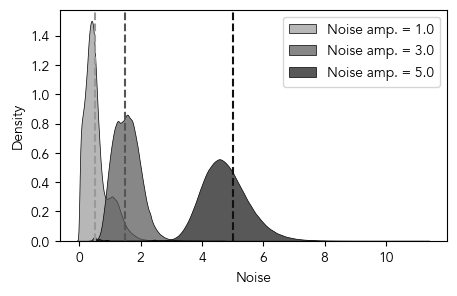

In [18]:
fig = plt.figure(figsize=(5, 3))

sns.kdeplot(
    posterior_noise[0.5],
    color="#999999",
    fill=True,
    edgecolor="k",
    lw=0.5,
    alpha=0.7,
    label="Noise amp. = 1.0",
)
sns.kdeplot(
    posterior_noise[1.5],
    color="#555555",
    fill=True,
    edgecolor="k",
    lw=0.5,
    alpha=0.7,
    label="Noise amp. = 3.0",
)
sns.kdeplot(
    posterior_noise[5],
    color="#111111",
    fill=True,
    edgecolor="k",
    lw=0.5,
    alpha=0.7,
    label="Noise amp. = 5.0",
)

plt.axvline(0.5, linestyle="dashed", lw=1.5, color="#999999")
plt.axvline(1.5, linestyle="dashed", lw=1.5, color="#555555")
plt.axvline(5, linestyle="dashed", lw=1.5, color="#111111")

plt.xlabel("Noise")
plt.legend()

##  Summary Figure (Fig. 11)
Plot example proxy data, proxy signal inferences, and signal recovery metrics using the combined results from all 3 trials.

In [36]:
# concatenate posterior proxy signals for trials 1-3, and save the outputs in .pkl files

amp = 0.5
full_trace_white = stratmc.data.load_trace(trace_paths_white_1[amp])
ages = full_trace_white.X_new.X_new.values
proxy_pred = az.extract(full_trace_white.posterior_predictive)[
    "f_pred_" + "d13c"
].values
full_trace_white = stratmc.data.load_trace(trace_paths_white_2[amp])
proxy_pred = np.hstack(
    [
        proxy_pred,
        az.extract(full_trace_white.posterior_predictive)["f_pred_" + "d13c"].values,
    ]
)
full_trace_white = stratmc.data.load_trace(trace_paths_white_3[amp])
proxy_pred = np.hstack(
    [
        proxy_pred,
        az.extract(full_trace_white.posterior_predictive)["f_pred_" + "d13c"].values,
    ]
)

stratmc.data.save_object(proxy_pred, "data/Fig11b_white_noise_proxy_signal_0.5")

amp = 1.5
full_trace_white = stratmc.data.load_trace(trace_paths_white_1[amp])
ages = full_trace_white.X_new.X_new.values
proxy_pred = az.extract(full_trace_white.posterior_predictive)[
    "f_pred_" + "d13c"
].values
full_trace_white = stratmc.data.load_trace(trace_paths_white_2[amp])
proxy_pred = np.hstack(
    [
        proxy_pred,
        az.extract(full_trace_white.posterior_predictive)["f_pred_" + "d13c"].values,
    ]
)
full_trace_white = stratmc.data.load_trace(trace_paths_white_3[amp])
proxy_pred = np.hstack(
    [
        proxy_pred,
        az.extract(full_trace_white.posterior_predictive)["f_pred_" + "d13c"].values,
    ]
)

stratmc.data.save_object(proxy_pred, "data/Fig11b_white_noise_proxy_signal_1.5")

amp = 5
full_trace_white = stratmc.data.load_trace(trace_paths_white_1[amp])
ages = full_trace_white.X_new.X_new.values
proxy_pred = az.extract(full_trace_white.posterior_predictive)[
    "f_pred_" + "d13c"
].values
full_trace_white = stratmc.data.load_trace(trace_paths_white_2[amp])
proxy_pred = np.hstack(
    [
        proxy_pred,
        az.extract(full_trace_white.posterior_predictive)["f_pred_" + "d13c"].values,
    ]
)
full_trace_white = stratmc.data.load_trace(trace_paths_white_3[amp])
proxy_pred = np.hstack(
    [
        proxy_pred,
        az.extract(full_trace_white.posterior_predictive)["f_pred_" + "d13c"].values,
    ]
)

# stratmc.data.save_object(proxy_pred, 'data/Fig11b_white_noise_proxy_signal_5')

/Users/staceyedmonsond/opt/anaconda3/envs/bayestrat-dev-m1-pymc516-accelerate/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: X_new group is not defined in the InferenceData scheme
  warnings.warn(


In [19]:
## load concatenated posterior proxy signals for trials 1-3 (instead of running the above cell)
proxy_pred = {}
proxy_pred[0.5] = stratmc.data.load_object("data/Fig11b_white_noise_proxy_signal_0.5")
proxy_pred[1.5] = stratmc.data.load_object("data/Fig11b_white_noise_proxy_signal_1.5")
proxy_pred[5] = stratmc.data.load_object("data/Fig11b_white_noise_proxy_signal_5")

# grab the posterior predictive age vector for plotting
full_trace_white = stratmc.data.load_trace(trace_paths_white_3[0.5])
predict_ages = full_trace_white.X_new.X_new.values
del full_trace_white

/Users/staceyedmonsond/opt/anaconda3/envs/bayestrat-dev-m1-pymc516-accelerate/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: X_new group is not defined in the InferenceData scheme
  warnings.warn(


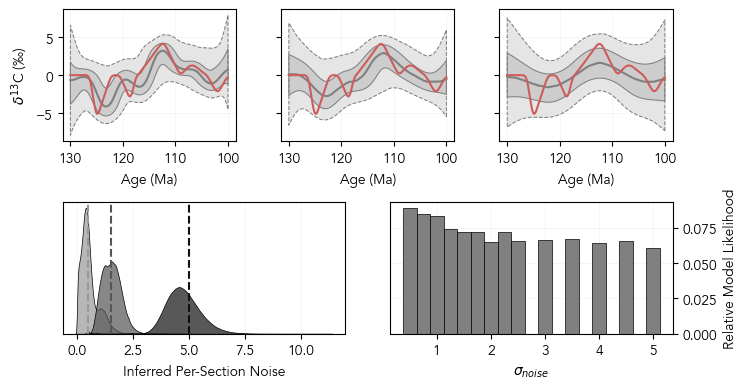

In [17]:
mosaic = """
    112233
    444555
    """

fs = 10
fig, ax = plt.subplot_mosaic(
    mosaic, figsize=(7.5, 4), sharex=False, sharey=False, constrained_layout=False
)

ax["1"].sharex(ax["2"])
ax["2"].sharex(ax["3"])
ax["1"].sharey(ax["2"])
ax["2"].sharey(ax["3"])

# signal inferences (averaged across all 3 trials) for noise with amplitiude of 1, 3, and 5 sigma (subplots 1, 2, 3)
# amplitude = 0.5
amp = 0.5

hi = np.percentile(proxy_pred[amp], 97.5, axis=1).flatten()

lo = np.percentile(proxy_pred[amp], 2.5, axis=1).flatten()

ax["1"].fill_between(
    predict_ages.ravel(),
    hi,
    lo,
    color="white",
    linestyle="--",
    edgecolor="none",
    alpha=1,
    lw=0,
    zorder=1,
)

ax["1"].fill_between(
    predict_ages.ravel(),
    hi,
    lo,
    color="black",
    linestyle="--",
    edgecolor="none",
    alpha=0.1,
    lw=0,
    zorder=2,
)

ax["1"].fill_between(
    predict_ages.ravel(),
    hi,
    lo,
    color="none",
    label="95% envelope",
    linestyle="--",
    edgecolor="gray",
    alpha=1,
    lw=0.75,
    zorder=3,
)

hi = np.percentile(proxy_pred[amp], 100 - 16, axis=1).flatten()

lo = np.percentile(proxy_pred[amp], 16, axis=1).flatten()

ax["1"].fill_between(
    predict_ages.ravel(),
    hi,
    lo,
    color="black",
    edgecolor="none",
    alpha=0.1,
    lw=0,
    zorder=4,
)

ax["1"].fill_between(
    predict_ages.ravel(),
    hi,
    lo,
    color="none",
    label="68% envelope",
    edgecolor="gray",
    alpha=1,
    lw=0.75,
    zorder=5,
)

dy = np.linspace(np.min(proxy_pred[amp]), np.max(proxy_pred[amp]), 400)
max_like = np.zeros(predict_ages.size)
for i in np.arange(predict_ages.size):
    time_slice = proxy_pred[amp][i, :]
    max_like[i] = dy[np.argmax(gaussian_kde(time_slice, bw_method=1)(dy))]

max_like = gaussian(max_like, 2)
ax["1"].plot(
    predict_ages.ravel(),
    max_like,
    color="gray",
    linestyle="solid",
    lw=1.5,
    zorder=6,
    label="Most likely $\delta^{13}$C",
)

ax["1"].plot(
    age_vector, d13c_signal, color="indianred", lw=1.5, label="True Signal", zorder=10
)

# amplitude = 1.5
amp = 1.5

hi = np.percentile(proxy_pred[amp], 97.5, axis=1).flatten()

lo = np.percentile(proxy_pred[amp], 2.5, axis=1).flatten()

ax["2"].fill_between(
    predict_ages.ravel(),
    hi,
    lo,
    color="white",
    linestyle="--",
    edgecolor="none",
    alpha=1,
    lw=0,
    zorder=1,
)

ax["2"].fill_between(
    predict_ages.ravel(),
    hi,
    lo,
    color="black",
    linestyle="--",
    edgecolor="none",
    alpha=0.1,
    lw=0,
    zorder=2,
)

ax["2"].fill_between(
    predict_ages.ravel(),
    hi,
    lo,
    color="none",
    label="95% envelope",
    linestyle="--",
    edgecolor="gray",
    alpha=1,
    lw=0.75,
    zorder=3,
)

hi = np.percentile(proxy_pred[amp], 100 - 16, axis=1).flatten()

lo = np.percentile(proxy_pred[amp], 16, axis=1).flatten()

ax["2"].fill_between(
    predict_ages.ravel(),
    hi,
    lo,
    color="black",
    edgecolor="none",
    alpha=0.1,
    lw=0,
    zorder=4,
)

ax["2"].fill_between(
    predict_ages.ravel(),
    hi,
    lo,
    color="none",
    label="68% envelope",
    edgecolor="gray",
    alpha=1,
    lw=0.75,
    zorder=5,
)

dy = np.linspace(np.min(proxy_pred[amp]), np.max(proxy_pred[amp]), 400)
max_like = np.zeros(predict_ages.size)
for i in np.arange(predict_ages.size):
    time_slice = proxy_pred[amp][i, :]
    max_like[i] = dy[np.argmax(gaussian_kde(time_slice, bw_method=1)(dy))]

max_like = gaussian(max_like, 2)
ax["2"].plot(
    predict_ages.ravel(),
    max_like,
    color="gray",
    linestyle="solid",
    lw=1.5,
    zorder=6,
    label="Most likely $\delta^{13}$C",
)

ax["2"].plot(
    age_vector, d13c_signal, color="indianred", lw=1.5, label="True Signal", zorder=10
)

# amplitude = 5
amp = 5

hi = np.percentile(proxy_pred[amp], 97.5, axis=1).flatten()

lo = np.percentile(proxy_pred[amp], 2.5, axis=1).flatten()

ax["3"].fill_between(
    predict_ages.ravel(),
    hi,
    lo,
    color="white",
    linestyle="--",
    edgecolor="none",
    alpha=1,
    lw=0,
    zorder=1,
)

ax["3"].fill_between(
    predict_ages.ravel(),
    hi,
    lo,
    color="black",
    linestyle="--",
    edgecolor="none",
    alpha=0.1,
    lw=0,
    zorder=2,
)

ax["3"].fill_between(
    predict_ages.ravel(),
    hi,
    lo,
    color="none",
    label="95% envelope",
    linestyle="--",
    edgecolor="gray",
    alpha=1,
    lw=0.75,
    zorder=3,
)

hi = np.percentile(proxy_pred[amp], 100 - 16, axis=1).flatten()

lo = np.percentile(proxy_pred[amp], 16, axis=1).flatten()

ax["3"].fill_between(
    predict_ages.ravel(),
    hi,
    lo,
    color="black",
    edgecolor="none",
    alpha=0.1,
    lw=0,  # 1.5
    zorder=4,
)

ax["3"].fill_between(
    predict_ages.ravel(),
    hi,
    lo,
    color="none",
    label="68% envelope",
    edgecolor="gray",
    alpha=1,
    lw=0.75,  # 1.5
    zorder=5,
)

dy = np.linspace(np.min(proxy_pred[amp]), np.max(proxy_pred[amp]), 400)
max_like = np.zeros(predict_ages.size)
for i in np.arange(predict_ages.size):
    time_slice = proxy_pred[amp][i, :]
    max_like[i] = dy[np.argmax(gaussian_kde(time_slice, bw_method=1)(dy))]

max_like = gaussian(max_like, 2)
ax["3"].plot(
    predict_ages.ravel(),
    max_like,
    color="gray",
    linestyle="solid",
    lw=1.5,
    zorder=6,
    label="Most likely $\delta^{13}$C",
)

ax["3"].plot(
    age_vector, d13c_signal, color="indianred", lw=1.5, label="True Signal", zorder=10
)

[t.set_color("none") for t in ax["2"].yaxis.get_ticklabels()]
[t.set_color("none") for t in ax["3"].yaxis.get_ticklabels()]

# posterior noise terms (loaded from .pkl in earlier cell)
sns.kdeplot(
    posterior_noise[0.5],
    color="#999999",
    fill=True,
    edgecolor="k",
    lw=0.5,
    ax=ax["4"],
    alpha=0.7,
)
sns.kdeplot(
    posterior_noise[1.5],
    color="#555555",
    fill=True,
    edgecolor="k",
    lw=0.5,
    ax=ax["4"],
    alpha=0.7,
)
sns.kdeplot(
    posterior_noise[5],
    color="#111111",
    fill=True,
    edgecolor="k",
    lw=0.5,
    ax=ax["4"],
    alpha=0.7,
)

ax["4"].axvline(0.5, linestyle="dashed", lw=1.5, color="#999999")
ax["4"].axvline(1.5, linestyle="dashed", lw=1.5, color="#555555")
ax["4"].axvline(5, linestyle="dashed", lw=1.5, color="#111111")

ax["4"].set_xlabel("Inferred Per-Section Noise", fontsize=fs)
ax["4"].set_yticks([])
ax["4"].set_ylabel("")

for amp in noise_amp:
    vec = [
        np.mean(relative_model_likelihood_white_1[amp]),
        np.mean(relative_model_likelihood_white_2[amp]),
        np.mean(relative_model_likelihood_white_3[amp]),
    ]
    ax["5"].bar(amp, np.mean(vec), width=0.25, color="gray", edgecolor="k", lw=0.5)

ax["5"].set_ylabel("Relative Model Likelihood", fontsize=fs)
ax["5"].set_xlabel("$\sigma_{noise}$", fontsize=fs)

ax["5"].yaxis.set_label_position("right")
ax["5"].yaxis.tick_right()

for i in "123":
    ax[i].set_xlabel("Age (Ma)", fontsize=fs)

ax["1"].set_ylabel("$\delta^{13}$C (‰)", fontsize=fs)

ax["1"].invert_xaxis()

for i in "12345":
    ax[i].set_axisbelow(True)
    ax[i].grid(color=(0.95, 0.95, 0.95), linewidth=0.5, linestyle="solid", zorder=-1)
    ax[i].tick_params(labelsize=fs)

fig.tight_layout()